# Multi-criteria approach
- This notebook shows how to use this package, and more specifically part 3 (Multi-criteria approach for Community Detection)
- Please check other notebooks for other parts (data generation and contestant approaches)

## Example 1: Generate results and plot them
- Generating data (graphs) following a set of parameters
- Running the multi-criteria approach on those graphs and aggregating results
- Plotting results

In [12]:
from moo.data_generation import ExpConfig, DataGenerator

# Configuration for Fig 06
fig06_expconfig = ExpConfig(
    L=30, U=30, NumEdges=100, ML=0.5, MU=0.5, BC=0.1, NumGraphs=5, # 30 graphs in the paper
    shuffle=False,
    seed=None,
)
print('Fig 06 ', fig06_expconfig)

Fig 06  <ExpConfig: L=30, U=30, NumNodes=60, NumEdges=100, ML=0.5, MU=0.5, BC=0.1, NumGraphs=5, shuffle=False, seed=42>


In [13]:
# Generate data
expgen = DataGenerator(expconfig=fig06_expconfig) # Pass defined parameters
print(expgen)
datagen = expgen.generate_data() # datagen is an iterator

<DataGenerator: ExpConfig: L=30, U=30, NumNodes=60, NumEdges=100, ML=0.5, MU=0.5, BC=0.1, NumGraphs=5, shuffle=False, seed=42>


In [14]:
# Instantiate the algorithm (change mode to '2d' to use the 2d approach)
from moo.multicriteria import ComDetMultiCriteria
import pandas as pd

algo = ComDetMultiCriteria(
    name='3d',
    params = {
        'mode': '3d', # '2d' for 2d approach
        'popsize': 50,
        'termination': None, # By default it runs for 1000 generations (or pass a pymoo termination instance)
        'save_history': False, # set to True for later hypervolume calculations
        'seed': None, # For reproducibility
    }
)


# Run the community detection algorithm on the generated graphs
results = [] # Holds results of community detection algorithms (list of dictionaries)
for g_idx, graph in enumerate(datagen):
    print(f'Processing Graph {g_idx+1}')
    result = algo.detect_communities(graph=graph).get_results()
    # Result is a list of dictionaries, each dictionary stores the metrics of one iteration (see code for details)
    print('Done')
    for r in result: # Appending graph index to results, for debugging purposes
        r['graph_idx'] = g_idx + 1
    results.extend(result)

# Save results in a dataframe
df = pd.DataFrame(results) # Column names are inferred from the dictionaries' keys
df.head()

Processing Graph 1
Done
Processing Graph 2
Done
Processing Graph 3
Done
Processing Graph 4
Done
Processing Graph 5
Done


,name,num_clusters,modularity_score,modularity_score_1,modularity_score_2,adj_rand_index,graph_idx
0,3d,2,0.40395,0.374422,0.368146,0.857199,1
1,3d,3,0.45855,0.389157,0.369980,0.547871,1
2,3d,4,0.43965,0.381665,0.377015,0.603538,1
3,3d,3,0.44855,0.385619,0.377015,0.602253,1
4,3d,1,0.00000,0.000000,0.000000,0.000000,1


(-0.1, 1.1)

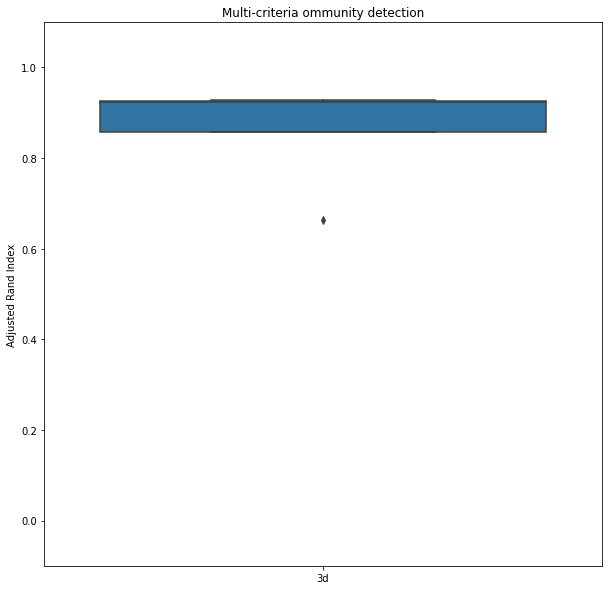

In [15]:
# Extract best solutions for each graph/algorithm pair
from moo.contestant import get_best_community_solutions, draw_best_community_solutions
best_solutions = get_best_community_solutions(df)

# Plot results
import matplotlib.pyplot as plt
from moo.contestant import draw_best_community_solutions
fix, ax = plt.subplots(figsize=(10,10))
ax, stats = draw_best_community_solutions(best_solutions, ax)
ax.set_title("Multi-criteria ommunity detection")
ax.set_xlabel("")
ax.set_ylabel("Adjusted Rand Index")
min_y = min(df.adj_rand_index.min(), 0) -0.1 # Accounts for BRIM results
ax.set_ylim(min_y,1.1)

## Example 2: Convergence analysis using the Hypervolume indicator
- Generating data (graphs) following a set of parameters
- Running the multi-criteria approach on those graphs and aggregating results
- Plotting the Hypervolume

In [16]:
from moo.data_generation import ExpConfig, DataGenerator
from moo.multicriteria import ComDetMultiCriteria
import pandas as pd

# Configuration for Fig 06 (one graph only for illustration purposes)
fig06_expconfig = ExpConfig(
    L=30, U=30, NumEdges=100, ML=0.5, MU=0.5, BC=0.1, NumGraphs=1, # 30 graphs in the paper
    shuffle=False,
    seed=None,
)

# Generate data
expgen = DataGenerator(expconfig=fig06_expconfig) # Pass defined parameters
datagen = expgen.generate_data() # datagen is an iterator

# Instantiate the algorithm (change mode to '2d' to use the 2d approach)
# Please note that history needs to be enabled

algo = ComDetMultiCriteria(
    name='3d',
    params = {
        'mode': '3d', # '2d' for 2d approach
        'popsize': 50,
        'termination': None, # By default it runs for 1000 generations (or pass a pymoo termination instance)
        'save_history': True, # set to True for later hypervolume calculations
        'seed': None, # For reproducibility
    }
)

# Run the community detection algorithm on the generated graphs
results = [] # Holds results of community detection algorithms (list of dictionaries)
for g_idx, graph in enumerate(datagen):
    print(f'Processing Graph {g_idx+1}')
    result = algo.detect_communities(graph=graph).get_results()
    # Result is a list of dictionaries, each dictionary stores the metrics of one iteration (see code for details)
    print('Done')
    for r in result: # Appending graph index to results, for debugging purposes
        r['graph_idx'] = g_idx + 1
    results.extend(result)

# Save results in a dataframe
df = pd.DataFrame(results) # Column names are inferred from the dictionaries' keys
df.head()


Processing Graph 1
Done


,name,num_clusters,modularity_score,modularity_score_1,modularity_score_2,adj_rand_index,graph_idx
0,3d,2,0.40395,0.374422,0.368146,0.857199,1
1,3d,3,0.45855,0.389157,0.369980,0.547871,1
2,3d,4,0.43965,0.381665,0.377015,0.603538,1
3,3d,3,0.44855,0.385619,0.377015,0.602253,1
4,3d,1,0.00000,0.000000,0.000000,0.000000,1


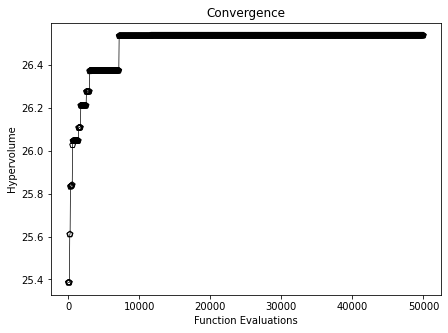

In [17]:
# Compute the Hypervolume indicator
n_evals, hv = algo.compute_hypervolume()

 # Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()
 